# Lab 4: Dimensionality reduction and working with textual data

## Dimensionality reduction

Suppose we have a dataset $X$, containing $N$ samples with $d$ features. This means that $X$ is matrix of size $N$ x $d$. You can think of this matrix as containing $N$ vectors in a $d$-dimensional space. Each feature is thus a dimension of the input data.

So far, we have mostly used datasets where $d$ is relatively small. Realistic datasets usually have much larger input dimensions $d$. Often, as a preprocessing step, you will reduce the dimensionality of the dataset. There are several reasons for doing so:
* In most learning algorithms, the complexity depends on both $N$ and $d$. By reducing the dimensionality of the problem, we can reduce memory and computation.
* Simpler models are more robust on small datasets. 
* When data can be explained with fewer features, we get a better idea about the process that underlies the data.
* When data can be represented in a few dimensions without loss of information, it can be plotted and analyzed visually for structure and outliers.

There are two main methods for reducing dimensionality: feature *selection* and feature *extraction*. In feature selection, we are interested in finding $k < d$ dimensions, that give us the most information, and we simply discard the other $(d-k)$ dimensions. This means that we are removing $k$ columns from the $X$ matrix, leaving the other columns unmodified. In feature derivation, we are interesting in finding a **new** set of $k$ dimensions that are combinations of the original $d$ dimensions. 
This means that we will not simply discard a number of dimensions from the input data, but transform each original datapoint (in $N$-dimensional space) to a point in a $k$-dimensional space. 

Mathematically, this means we need to find a $k$ x $d$ matrix $W$ to transform $X$ into a $N$ x $k$ matrix $X_{new}$:
$$
X_{new} = X.W^T
$$

In this lab session, we will focus on **Principal Component Analysis (PCA)**. This is an unsupervised and unparameterized ML method for **dimensionality reduction**.
Dimensionality reduction can be seen as a lossy compression technique.

## What is a good set of new dimensions to represent the data?

Of course, we need to find a good set of $k$ dimensions. Before delving into the mathematical principles on how to do this, let us first get some intuition by considering an elementary example.

Suppose we have a dataset $X$, containing $N=150$ samples with $d=2$ features. Since $d=2$, we can visualize this data:

Dimension of X:  (150, 2)


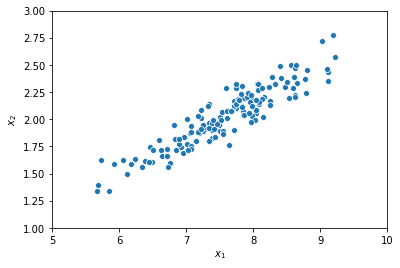

In [1]:
import numpy as np
import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt

from utils import generate_anisotropicgaussian, plot2DScatter
X = generate_anisotropicgaussian(150,2)    
plot2DScatter(X)

print('Dimension of X: ', X.shape)

We can fit an ellipsoid around this data.

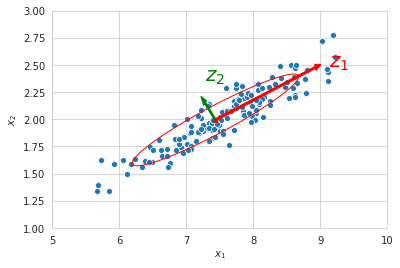

In [2]:
from utils import plotscatterwithellipse
    
plotscatterwithellipse(X,xmin=5,xmax=10,ymin=1,ymax=3)

The centre of the ellipsoid is the centroid of the data. The axes of this ellipsoid are called the **principal components** of this data. They are the **directions of highest variance**. The first principal component is the red axis $z_1$ on the figure above. We can now use the axes $z_1$ and $z_2$ as a new coordinate system. Each datapoint will have new coordinates in this system.

Finding the principal components could thus be seen as first centering the dataset (subtracting the mean along each feature dimension) and then rotating the axes of the coordinate system to line up with the directions of the highest variance. Mathematically, we say that we **project** the data onto the new coordinate system. The plot below shows the centered and lined-up ellips, with each datapoint $x$ now having coordinates in the new coordinate system.

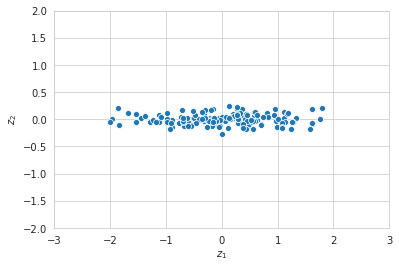

In [3]:
from utils import plotProjection
plotProjection(X)

If you look at the plot above. Suppose we would represent each datapoint with only one feature: $z_1$. We would reduce the dimension of our dataset from $d=2$ to $d=1$, without loosing a lot of relevant information. In this particular example, the variance along $z_2$ may even be due from noise. 

What we have done in the above is to identify the 2 directions of largest variance (the axes of the ellipse) of 2-dimensional data, and projected our data on these principal components. We then concluded that we could keep only a subset of the features in this new coordinate system (in particular, only one dimension) without losing much of information. This is exactly the idea of **Principal Component Analysis for dimensionality reduction**. 

To generalize this to higher dimensional data ($d > 2$), we need to find answers to the following questions:
* how can we find the $d$ directions of largest variance (the principal components)
* how much information do we loose if we only keep $k < d$ directions of largest variance.

This is studied in the sections below.

## The data: breast cancer dataset 
To experiment with PCA we will use a dataset with a large number of characteristics of the cell nuclei from breast biopsy. This dataset was constructed for exercises on binary classification: each data item is labeled as 'benign' (no cancer) or 'malign'. You can also use it from clustering tasks where you hope to group all the benign samples together in one cluster and the malign samples in another cluster. In this exercise, we will use it for dimensionality reduction. The 30 features make it impossible to visually inspect the data. We will transform the 30 dimensional feature representation into a lower dimensional one that is easier to interpret for a human but hopefully also for a downstream machine learning model.

In [4]:
from sklearn.datasets import load_breast_cancer
import pandas as pd

cancer = load_breast_cancer()
print('Dimensions of dataset: ')
print(cancer.data.shape)
print(cancer.target.shape)

df = pd.DataFrame(cancer['data'],columns=cancer['feature_names'])

print('First elements in the dataset:')
df.head()

Dimensions of dataset: 
(569, 30)
(569,)
First elements in the dataset:


,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


## PCA
To apply PCA, we need to perform the following steps:
1. Normalize the dataset.
2. Compute the covariance matrix of the whole dataset.
3. Compute eigenvectors and the corresponding eigenvalues.
4. Sort the eigenvectors by decreasing eigenvalues and choose k eigenvectors with the largest eigenvalues to form a d × k dimensional matrix W.
5. Use this d × k eigenvector matrix to transform the samples onto the new subspace.

### Step 1: dataset normalization
For PCA to work properly, you have to subtract the mean from each of the data dimensions. The code below uses the *StandardScaler* from Scikit-learn. This also normalizes the data to have a standard deviation of one.

In [5]:
#The data is in a dataframe "df". Standardize this data
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaled_data = scaler.fit_transform(df)
scaled_data = pd.DataFrame(scaled_data, columns=df.columns)
scaled_data.head()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
0,1.097064,-2.073335,1.269934,0.984375,1.568466,3.283515,2.652874,2.532475,2.217515,2.255747,...,1.886690,-1.359293,2.303601,2.001237,1.307686,2.616665,2.109526,2.296076,2.750622,1.937015
1,1.829821,-0.353632,1.685955,1.908708,-0.826962,-0.487072,-0.023846,0.548144,0.001392,-0.868652,...,1.805927,-0.369203,1.535126,1.890489,-0.375612,-0.430444,-0.146749,1.087084,-0.243890,0.281190
2,1.579888,0.456187,1.566503,1.558884,0.942210,1.052926,1.363478,2.037231,0.939685,-0.398008,...,1.511870,-0.023974,1.347475,1.456285,0.527407,1.082932,0.854974,1.955000,1.152255,0.201391
3,-0.768909,0.253732,-0.592687,-0.764464,3.283553,3.402909,1.915897,1.451707,2.867383,4.910919,...,-0.281464,0.133984,-0.249939,-0.550021,3.394275,3.893397,1.989588,2.175786,6.046041,4.935010
4,1.750297,-1.151816,1.776573,1.826229,0.280372,0.539340,1.371011,1.428493,-0.009560,-0.562450,...,1.298575,-1.466770,1.338539,1.220724,0.220556,-0.313395,0.613179,0.729259,-0.868353,-0.397100


In [6]:
scaled_data.describe()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
count,5.690000e+02,5.690000e+02,5.690000e+02,5.690000e+02,5.690000e+02,5.690000e+02,5.690000e+02,5.690000e+02,5.690000e+02,5.690000e+02,...,5.690000e+02,5.690000e+02,5.690000e+02,5.690000e+02,5.690000e+02,5.690000e+02,5.690000e+02,5.690000e+02,5.690000e+02,5.690000e+02
mean,-3.153111e-15,-6.568462e-15,-6.993039e-16,-8.553985e-16,6.081447e-15,-1.136369e-15,-2.997017e-16,1.023981e-15,-1.860648e-15,-1.504752e-15,...,-2.297713e-15,1.742016e-15,-1.198807e-15,6.118909e-16,-5.094929e-15,-2.122887e-15,6.118909e-16,-1.998011e-16,-2.422589e-15,2.497514e-15
std,1.000880e+00,1.000880e+00,1.000880e+00,1.000880e+00,1.000880e+00,1.000880e+00,1.000880e+00,1.000880e+00,1.000880e+00,1.000880e+00,...,1.000880e+00,1.000880e+00,1.000880e+00,1.000880e+00,1.000880e+00,1.000880e+00,1.000880e+00,1.000880e+00,1.000880e+00,1.000880e+00
min,-2.029648e+00,-2.229249e+00,-1.984504e+00,-1.454443e+00,-3.112085e+00,-1.610136e+00,-1.114873e+00,-1.261820e+00,-2.744117e+00,-1.819865e+00,...,-1.726901e+00,-2.223994e+00,-1.693361e+00,-1.222423e+00,-2.682695e+00,-1.443878e+00,-1.305831e+00,-1.745063e+00,-2.160960e+00,-1.601839e+00
25%,-6.893853e-01,-7.259631e-01,-6.919555e-01,-6.671955e-01,-7.109628e-01,-7.470860e-01,-7.437479e-01,-7.379438e-01,-7.032397e-01,-7.226392e-01,...,-6.749213e-01,-7.486293e-01,-6.895783e-01,-6.421359e-01,-6.912304e-01,-6.810833e-01,-7.565142e-01,-7.563999e-01,-6.418637e-01,-6.919118e-01
50%,-2.150816e-01,-1.046362e-01,-2.359800e-01,-2.951869e-01,-3.489108e-02,-2.219405e-01,-3.422399e-01,-3.977212e-01,-7.162650e-02,-1.782793e-01,...,-2.690395e-01,-4.351564e-02,-2.859802e-01,-3.411812e-01,-4.684277e-02,-2.695009e-01,-2.182321e-01,-2.234689e-01,-1.274095e-01,-2.164441e-01
75%,4.693926e-01,5.841756e-01,4.996769e-01,3.635073e-01,6.361990e-01,4.938569e-01,5.260619e-01,6.469351e-01,5.307792e-01,4.709834e-01,...,5.220158e-01,6.583411e-01,5.402790e-01,3.575891e-01,5.975448e-01,5.396688e-01,5.311411e-01,7.125100e-01,4.501382e-01,4.507624e-01
max,3.971288e+00,4.651889e+00,3.976130e+00,5.250529e+00,4.770911e+00,4.568425e+00,4.243589e+00,3.927930e+00,4.484751e+00,4.910919e+00,...,4.094189e+00,3.885905e+00,4.287337e+00,5.930172e+00,3.955374e+00,5.112877e+00,4.700669e+00,2.685877e+00,6.046041e+00,6.846856e+00


### Step 2: Compute the covariance matrix of the whole dataset
- The variance of a variable measures the *spread* of its values.
- The covariance of two variables $X$ and $Y$ measures how much they vary from the mean with respect to each other. It gives you an intuition of how the value of $Y$ will change if the value of $X$ changes. If you calculate the covariance between one dimension and itself, you get the variance. The covariance can be computed as follows: $Cov(X,Y) = \sum_{i=1}^n\left(X_i - \bar{X} \right) \left(Y_i - \bar{Y} \right)$
- If we have a data set with more than 2 dimensions, there is more than one covariance measurement that can be calculated. A useful way to get all the possible covariance values between all the different dimensions is to calculate them all and put them in a matrix: the covariance matrix. The covariance matrix of $X$ can be calculated easily as $C = (X - X_{mean})^T \cdot (X - X_{mean})$. Note that $X_{mean}$ is a matrix where all elements of column $i$ are identical and have the mean value of feature $x_i$ in the dataset. Because the variance between feature $x_i$ and $x_j$ is the same as the variance between feature $x_j$ and $x_i$, $C$ is a symmetric matrix.

<font color='red'>Task: Calculate the covariance matrix from the scaled data. This is made easy in pandas using the .cov() method: https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.cov.html</font>

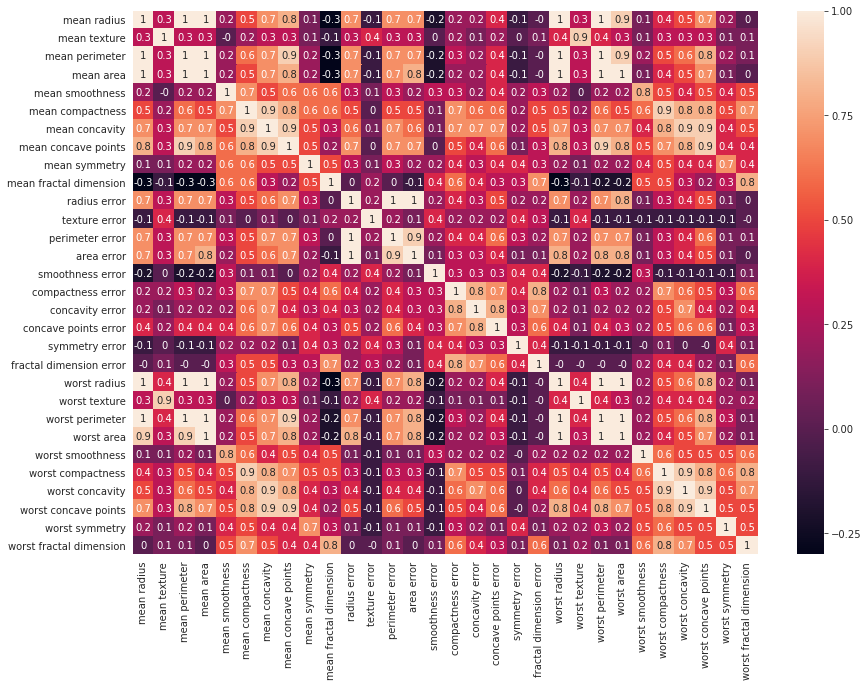

In [7]:
cov_matrix = scaled_data.cov()
plt.figure(figsize=(14,10))
sns.heatmap(data=cov_matrix.round(1), annot=True)

### Step 3: Compute eigenvectors and the corresponding eigenvalues.

The **eigenvectors** $v$ of a matrix $A$ are the vectors $v$ such that if you multiply $A$ with $v$, you get a multiple of $v$.
$$ A v = \lambda v $$
The scalar $\lambda$ is called the **eigenvalue** that belongs to the eigenvector $v$. Eigenvalues and eigenvectors are always coming in pairs - we speak about **eigenpairs**. 

intuitively, you can visualize a vector as a point in n-dimensional space. The matrix $A$ can then be seen as a **transformation matrix**. If you multiply this matrix with a vector, the result is another vector that is transformed from its original position. This is visualized in the animation below. The red vectors have changed their directions but the blue and pink ones still point in the same direction although their length has changed. These are the **eigenvectors** and their scaling factors are the **eigenvalues**.

<div style="float:left clear:both">
        <img src="images/eigenvector.gif" width="300" />
</div>


Eigenvectors have the following properties:
- They can only be found for square matrices.
- Not every square matrix has eigenvectors.
- Given an n*n matrix that does have eigenvectors, there are n of them.
- Eigenvectors are not unique: if $v$ is an eigenvector with eigenvalue $\lambda$, then also $\alpha v$ is an eigenvector, with eigenvalue $\lambda / \alpha$. In the rest, we consider only eigenvectors $v$ of unit length (with the associated $\lambda_i$).

Most importantly, all the eigenvectors of a matrix are perpendicular, i.e. at right angles to each other, no matter how many dimensions you have. This is important because it means that you can express the data in terms of these perpendicular eigenvectors, instead of expressing them in terms of the original x and y axes. Any $dxd$ symmetric matrix $A$ can be decomposed into the sum of its $d$ eigenvector products. By convention, we sort the eigenvalues $\lambda_i$ by size, so $\lambda_i >= \lambda_{i+1}$ (assuming $v$ is a row vector):
$$
A = \sum_{i=1}^d \lambda_i v_i v_i^T
$$

Since the covariance matrix is square, we can calculate the eigenvectors and eigenvalues for this matrix. As a result, we get d-dimensional vectors that describe the axes in the original data that have the highest variation.

<font color='red'>Task: Calculate the eigenvectors and eigenvalues from our covariance matrix. This is again made easy using numpy: https://numpy.org/doc/stable/reference/generated/numpy.linalg.eig.html</font>

In [8]:
evals, evecs = np.linalg.eig(cov_matrix)
print(evals.shape)
print(evals)

print(evecs.shape)

(30,)
[1.33049908e+01 5.70137460e+00 2.82291016e+00 1.98412752e+00
 1.65163324e+00 1.20948224e+00 6.76408882e-01 4.77456255e-01
 4.17628782e-01 3.51310875e-01 2.94433153e-01 2.61621161e-01
 2.41782421e-01 1.57286149e-01 9.43006956e-02 8.00034045e-02
 5.95036135e-02 5.27114222e-02 4.95647002e-02 1.33279057e-04
 7.50121413e-04 1.59213600e-03 6.91261258e-03 8.19203712e-03
 1.55085271e-02 1.80867940e-02 2.43836914e-02 2.74877113e-02
 3.12142606e-02 3.00256631e-02]
(30, 30)


### Step 4: Sort the eigenvectors by decreasing eigenvalues and choose k eigenvectors with the largest eigenvalues to form a d × k dimensional matrix W.

Let us now combine the insights of above. The covariance matrix $C$, calculated on dataset $X$, is a symmetric matrix. This means $C$ has $d$ orthogonal eigenvectors, which are the principal components of the dataset matrix $X$. Also, $C$ can be composed into the sum of its eigenpairs:

$$
C = \sum_{i=1}^d \lambda_i v_i v_i^T
$$

Remember that it is a convention to sort the eigenvalues in decreasing order. If we use only the first $k$ terms in the summation above, we still get a good approximation of the covariance. 

Dimensionality reduction by PCA thus means to project your data on the $k$ eigenvectors with the $k$ largest eigenvalues.

<font color='red'>Task: Extract the 2 eigenvectors with the highest eigenvalues</font>

In [9]:
indices = np.argsort(evals)[-2:]
good_evecs = evecs[:, indices]
good_evals = evals[indices]
print(good_evals.shape)
print(good_evecs.shape)

(2,)
(30, 2)


In [10]:
good_evecs

array([[-0.23385713,  0.21890244],
       [-0.05970609,  0.10372458],
       [-0.21518136,  0.22753729],
       [-0.23107671,  0.22099499],
       [ 0.18611302,  0.14258969],
       [ 0.15189161,  0.23928535],
       [ 0.06016536,  0.25840048],
       [-0.0347675 ,  0.26085376],
       [ 0.19034877,  0.13816696],
       [ 0.36657547,  0.06436335],
       [-0.10555215,  0.20597878],
       [ 0.08997968,  0.01742803],
       [-0.08945723,  0.21132592],
       [-0.15229263,  0.20286964],
       [ 0.20443045,  0.01453145],
       [ 0.2327159 ,  0.17039345],
       [ 0.19720728,  0.15358979],
       [ 0.13032156,  0.1834174 ],
       [ 0.183848  ,  0.04249842],
       [ 0.28009203,  0.10256832],
       [-0.21986638,  0.22799663],
       [-0.0454673 ,  0.10446933],
       [-0.19987843,  0.23663968],
       [-0.21935186,  0.22487053],
       [ 0.17230435,  0.12795256],
       [ 0.14359317,  0.21009588],
       [ 0.09796411,  0.22876753],
       [-0.00825724,  0.25088597],
       [ 0.14188335,

### Step 5: Use this 2 x 30 eigenvector matrix to transform the samples onto the new subspace.
<font color='red'>Task: Transform the data points to the new coordinates and visualize this as a scatter plot.</font>

(569, 30)
(30, 2)
(569, 2)


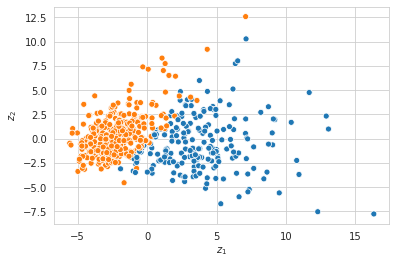

In [11]:
print(scaled_data.shape)
print(good_evecs.shape)
result = np.dot(scaled_data, good_evecs)
print(result.shape)

ax = sns.scatterplot(x=result[:,1],y=result[:,0],hue=cancer['target'],legend=False);
ax.set(xlabel='$z_1$', ylabel='$z_2$');

<font color='red'>Task: What do the different values in the eigenvectors represent ?</font>

- Each new dimension is a linear combination of the previous dimensions.
- To obtain a new point, you calculate the dot product (weighted sum).
- Each value represents the weight of the corresponding original dimension in this weighted sum.

Reflect on what you have achieved. You have represented the original 30-dimensional dataset with only 2 features. As the plot above, you did not lose much valuable information: the two clusters ('benign') and ('malign') can be relatively easily separated!


<font color='red'>Task: What happens if you use the two least important directions in the data ?</font>

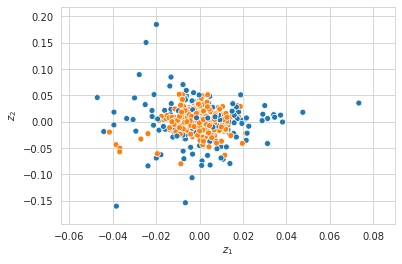

In [12]:
indices = np.argsort(evals)[:2]
bad_evecs = evecs[:, indices]

bad_result = np.dot(scaled_data, bad_evecs)

ax = sns.scatterplot(x=bad_result[:,0],y=bad_result[:,1],hue=cancer['target'],legend=False);
ax.set(xlabel='$z_1$', ylabel='$z_2$');

### PCA in Scikit-learn
As in all the previous assignments, there is a public available implementation available in Scikit-learn:  https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html

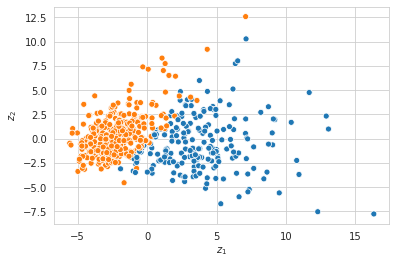

In [13]:
#Apply PCA with 2 components. Transform the data and plot the result. Documentation is at: https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html
from sklearn.decomposition import PCA
pca = PCA(n_components = 2)
data_reduced = pca.fit_transform(scaled_data)

ax = sns.scatterplot(x=data_reduced[:,0],y=data_reduced[:,1],hue=cancer['target'],legend=False);
ax.set(xlabel='$z_1$', ylabel='$z_2$');

## How do we determine the number of principal components?

In the previous exercise, we manually specified $k=2$ as the number of dimensions to reduce the dataset to. The choice for $k=2$ was mostly out of convenience, since it allowed us to nicely visualize the results. Obviously, in many cases $k=2$might be too restrictive. The lower $k$, the more we compress our dataset, but the more information about the variance we throw away. So, how to determine the optimal number of $k$?

Remember that the principal components were the eigenvectors $v_i$ (with unit length) of the covariance matrix C, with eigenvalues sorted in decreasing order ($\lambda_i > \lambda_{i+1}$).

$$
C = \sum_{i=1}^d \lambda_i v_i v_i^T
$$

Since (by convention) our eigenvectors have unit length, the ratio of the variance explained by the first $k$ principal components is:
$$
\frac{\lambda_1 + \lambda_2 + \dotsb + \lambda_k}{\lambda_1 + \lambda_2 + \dotsb + \lambda_k + \dotsb + \lambda_d}
$$


By plotting this ratio of explained variance as a function of $k$, we can apply the same elbow method as we used to determine the number of clusters in k-means clustering.

<font color='red'>Task: Create a new PCA object without specifying the number of components to use. The ratio above is available as an attribute of the pca object. You get the correct values by calculating a cumulative sum (np.cumsum) on this pca attribute.</font>

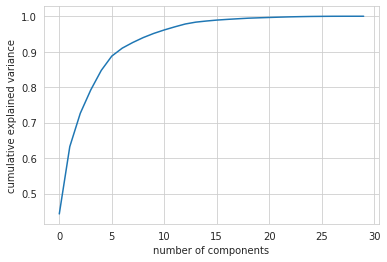

In [14]:
pca = PCA()
data_reduced = pca.fit_transform(scaled_data)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

<font color='red'>Task: With this insight, how much components would you use on our breast cancer dataset?.</font>

## t-SNE
A special case of dimensionality reduction is when the output number of dimensions is two (or three). This is done to manually inspect the data. PCA works fine for this 
but **T-distributed Stochastic Neighbor Embedding (t-SNE)** often gives more interpretable results if the goal is visualization.

t-SNE allows for a non-linear projection of the data while PCA only did a linear combination of features. The goal of t-SNE is not to explain the variance in the data but rather to use the local relationships between points to create a low-dimensional mapping. Two points that are close together in the high dimensional space will also be close together in the low dimensional space. This is not necessarily the case with PCA.


<font color='red'>Task: Use the scikit-learn t-SNE implementation on this dataset.</font>

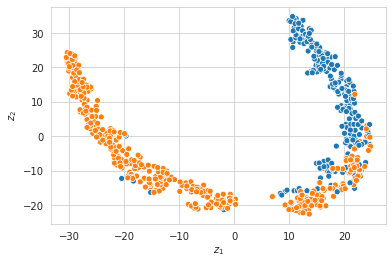

In [15]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2)
data_reduced = tsne.fit_transform(df)
ax = sns.scatterplot(x=data_reduced[:,0],y=data_reduced[:,1],hue=cancer['target'],legend=False);
ax.set(xlabel='$z_1$', ylabel='$z_2$');

## Remarks
- Be careful when using t-SNE, it is easy to misinterpret the output. See https://distill.pub/2016/misread-tsne/
- t-SNE does not define a function to reduce dimensionality, unlike PCA; t-SNE has no parameters, and directly optimizes the embeddings. In other words, you can train a t-SNE model on some data, but you can't use it to reduce the dimensionality of some new data points. You cannot use it as input for a classification model since you are unable to make predictions for new data.
- t-SNE is not deterministic, it will result in a different embedding every time. The optimization problem is also **non-convex** and might get stuck in a **local minimum**. 
- t-SNE involves hyperparameters to be tuned unlike PCA which does not have any hyperparameters. Handing hyperparameters incorrectly may lead to unwanted results.
- The PCA as explained in this sessions performs a linear combination of features. To enable a non-linear combination, you can use the **kernel trick** as explained in the next session. This results in **kernel PCA**.
- t-SNE has a quadratic time and space complexity in the number of data points. This makes it particularly slow for large datasets. It is possible to first use PCA to reduce the dimensionality before running t-SNE in this case.
- UMAP is a more recent algorithm that often gives superior results to t-SNE: https://umap-learn.readthedocs.io/en/latest/

# Feature extraction: Working with textual data

In the previous sessions, we worked with data stored in a tabular format. The rows represented individual datapoints and there was a column for each feature. This makes it easy for use to use it directly as input to a machine learning model that expects a matrix as input.

For many real world problems, you will need to first define and extract these features manually. In this exercise we will investigate how this can be done for textual data. Text data is a type of **unstructured data** since there is no predefined format for it. 

When working with textual data, you need to perform two steps prior to training your ML model **Data preprocessing** and **feature extraction**.

The preprocessing can include:
- **Tokenization**: converting sentences to words
- Removing unnecessary punctuation
- Removing urls, html markup, ...
- Removing **stop words**, frequent words such as "the", "is", "a", etc. that do not have specific semantic
- **Stemming**: words are reduced to a root by removing inflection through dropping unnecessary characters, usually a suffix.
- **Lemmatization**: Another approach to remove inflection by determining the part of speech and utilizing detailed database of the language.

The result of the preprocessing step is a list of words. We can use different approaches to extract features from these words to obtain numerical representations that we can give to machine learning models. The goal of this feature extraction step is to take a **document** (a collection of words) and to transform it into a numerical feature vector. The documents will vary in size but the feature vector usually has a fixed size. The collection of all documents is often called the **corpus** in text processing. We often use statistics of the corpus to obtain a feature representation for a single document.
- **Bag of Words (BOW)**: This is the simplest possible representation: We make the list of all the unique words in the text corpus, this is called the **vocabulary**. Then we can represent each document as a vector that indicates how many times each word from the vocabulary occurs in the document. This is a very simple method but can be useful in certain applications. In SPAM detection, we can expect that the words "stock", "Viagra", and "buy" can be indicative of SPAM emails. 
- A disadvantage is that this technique is only concerned with the occurrence of the word and not with the order of the words. It also treats each word independently.  You can solve this by introducing **n-gram generation** in the preprocessing step. n-grams are created by extracting all sequential n words from the document. **Bi-grams** for example extract all sequential pairs. The sentence "The president of the US is Joe Biden" will be transformed into \["The president", "president of", "of the", "the US", "US is", "is Joe", "Joe Biden"]. This is useful to capture terms consisting of multiple words. Bi-grams allow you to recognize both "Donald Trump" and "Donald Duck". Alternatively, you can also extract **tri-grams** (n=3).
- **TF-IDF**: shorthand for **term frequency-inverse document frequency**. Is a way of normalizing the BOW approach. It is the **term frequency** divided by the **document frequency**. Instead of just counting how many times a certain word occurs in the document (the term frequency) we divide it by the document frequency (the number of documents this word occurs in). A word that occurs often in a certain document but does not occur often in other documents is probably an important word for this document. 
- **Word embeddings**: Are the most advanced technique. A word embedding method transforms a word into a point in a high dimensional space where words that have a similar meaning are mapped to similar points. Word embeddings can be seen as a form of dimensionality reduction. This allows us to learn more complex relationships. The most common Word embedding technique is **Word2Vec**. It makes the assumption that two words that occur at a similar position in different sentences have more or less the same meaning. If you have the two sentences "BMW is a German car manufacturer" and "Tesla is an American automobile manufacturer", you can infer that "BMW" and "Tesla", "German" and "American" and "car" and "automobile" are related. Word embeddings are trained on a large text corpus such as wikipedia. You can find more information at https://pathmind.com/wiki/word2vec#import

## The data: health Tweets
In the following exercise we will use TF-IDF to extract features from "Health News in Twitter Data Set". This dataset contains different sets of sample tweets from various news channels like CNN, NYTimes, CBC etc.

In [16]:
import pandas as pd

#this function returns a dict with tweets loaded
def read_all_tweets():
    all_tweets = {}
    file = open("data/nytimeshealth.txt", "r",encoding="utf8")
    lines = file.readlines()
    for index, line in enumerate(lines):
        parts = line.split(sep="|", maxsplit=2)
        tweet = "".join(parts[2:len(parts)])
        all_tweets[index] = tweet
    file.close()
    return all_tweets


tweets_dict = read_all_tweets()
tweets = tweets_dict.values()

df = pd.DataFrame(list(tweets_dict.items()),columns=["Tweet Index","Tweet"])
print("Number of tweets in dataset: ",df.shape[0])
print(df.head(10))

Number of tweets in dataset:  6245
   Tweet Index                                              Tweet
0            0  Risks in Using Social Media to Spot Signs of M...
1            1  RT @paula_span: The most effective nationwide ...
2            2  The New Old Age Blog: Diabetes Prevention That...
3            3  Well: Comfort Casseroles for Winter Dinners ht...
4            4  High-Level Knowledge Before Veterans Affairs S...
5            5  Your Money: Affordable Care Act’s Tax Effects ...
6            6  Well: Christmas in the Hospital http://nyti.ms...
7            7  The Texas Tribune: For Members of Health Minis...
8            8  A q&amp;a with Laura Hillenbrand, author of "U...
9            9  Race to Deliver Nicotine’s Punch, With Less Ri...


<font color='red'>Task: Follow the instructions at https://scikit-learn.org/stable/tutorial/text_analytics/working_with_text_data.html to preprocess the data and to extract TF-IDF features. Experiment with different ngrams and the *min_df* and *max_df* parameters. These last two parameters allow you to remove terms that are present in only a few documents or in most of the documents.</font>

In [17]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

count_vect = CountVectorizer(
    stop_words="english",
    ngram_range=(1,2),
    min_df=2,
    max_df=0.5
)

X_train_counts = count_vect.fit_transform(df["Tweet"])

tf_transformer = TfidfTransformer()
X_train_tf = tf_transformer.fit_transform(X_train_counts)

<font color='red'>Task: How many features are extracted ? </font>

In [18]:
feature_names=count_vect.get_feature_names()
print(feature_names[:10])

print(len(feature_names))
print(X_train_tf.shape)

['00', '00 et', '000', '000 calories', '000 children', '000 deaths', '000 medical', '000 people', '01', '01 retracing']
9328
(6245, 9328)


In [19]:
X_train_tf

<6245x9328 sparse matrix of type '<class 'numpy.float64'>'
	with 59955 stored elements in Compressed Sparse Row format>

<font color='red'>Task: Look at the first tweet, what keywords are extracted and what is their tf-idf score ? </font>

In [20]:
print(df.at[0, "Tweet"])
features = X_train_tf[0]

terms = pd.DataFrame(features.T.todense(), index=feature_names, columns=["tfidf"])
terms.sort_values(by=["tfidf"],ascending=False).head(n=10)

Risks in Using Social Media to Spot Signs of Mental Distress http://nyti.ms/1rqi9I1



,tfidf
mental distress,0.355677
distress http,0.355677
distress,0.343836
social media,0.343836
spot,0.327147
signs,0.292271
social,0.289431
using,0.279701
risks,0.240706
mental,0.239059


<font color='red'>Task: Use these features to find the most similar documents using a NearestNeighbors algorithm. </font>

To calculate similarities you will need to define a **distance function**. The default **euclidian distance** is easy to interpret as it just calculates the length of the straight line between two points. In NLP, the cosine distance is often more useful. It looks at the angle between two vectors and is more robust in case of different document lengths. There are more advanced functions such as **Jaccard Similarity** or **Word Mover’s Distance** that are useful for some cases. See https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.DistanceMetric.html for an overview of the metrics that are supported by Scikit-learn.

<font color='red'>Task: Experiment with different distance functions. </font>


In [21]:
from sklearn.neighbors import NearestNeighbors

knn = NearestNeighbors(n_neighbors=5, metric="cosine")
knn.fit(X_train_tf.toarray())
distances, neighbors = knn.kneighbors(features)

for distance, neighbor in zip(distances[0], neighbors[0]):
    print(distance, df.at[neighbor, 'Tweet'], sep=":\t")

0.0:	Risks in Using Social Media to Spot Signs of Mental Distress http://nyti.ms/1rqi9I1

0.5587951379317673:	The New Old Age Blog: A Rising Tide of Mental Distress http://nyti.ms/12KknBT

0.6717851503123657:	Kathryn Morgan Uses Social Media as She Gears for Her Return http://nyti.ms/1AoEKDl

0.7131571264649024:	Young people who use social media say that fame is a motivating factor, USA Today reports. http://www.usatoday.com/story/news/nation/2013/04/18/social-media-tweens-fame/2091199/

0.7819107648618722:	Well: A Sleep Sweet Spot http://nyti.ms/1lNR6nm



In [22]:
from sklearn.neighbors import NearestNeighbors

knn = NearestNeighbors(n_neighbors=5, metric="euclidean")
knn.fit(X_train_tf.toarray())
distances, neighbors = knn.kneighbors(features.toarray())

for distance, neighbor in zip(distances[0], neighbors[0]):
    print(distance, df.at[neighbor, 'Tweet'], sep=":\t")

0.0:	Risks in Using Social Media to Spot Signs of Mental Distress http://nyti.ms/1rqi9I1

0.9999999999999999:	How to Invest in Dope http://nyti.ms/1aMgBwt

0.9999999999999999:	Well: Four Frittatas and a Terrine http://nyti.ms/18OZYOz

0.9999999999999999:	Well: Applause for Avocados http://nyti.ms/1f3jFV1

0.9999999999999999:	Well: Tonics and Teas http://nyti.ms/1lZ9io7



In [23]:
from sklearn.neighbors import NearestNeighbors

knn = NearestNeighbors(n_neighbors=5, metric="jaccard")
knn.fit(X_train_tf.toarray())
distances, neighbors = knn.kneighbors(features.toarray())

for distance, neighbor in zip(distances[0], neighbors[0]):
    print(distance, df.at[neighbor, 'Tweet'], sep=":\t")

0.0:	Risks in Using Social Media to Spot Signs of Mental Distress http://nyti.ms/1rqi9I1

0.7857142857142857:	Kathryn Morgan Uses Social Media as She Gears for Her Return http://nyti.ms/1AoEKDl

0.8095238095238095:	The New Old Age Blog: A Rising Tide of Mental Distress http://nyti.ms/12KknBT

0.90625:	Young people who use social media say that fame is a motivating factor, USA Today reports. http://www.usatoday.com/story/news/nation/2013/04/18/social-media-tweens-fame/2091199/

0.9090909090909091:	RT @celiadugger: Yes, there's insurance parity now for mental illness but shortage of docs, $ &amp; social supports. http://nyti.ms/1euoOJs



In [24]:
from sklearn.neighbors import NearestNeighbors

knn = NearestNeighbors(n_neighbors=5, metric="manhattan")
knn.fit(X_train_tf.toarray())
distances, neighbors = knn.kneighbors(features.toarray())

for distance, neighbor in zip(distances[0], neighbors[0]):
    print(distance, df.at[neighbor, 'Tweet'], sep=":\t")

0.0:	Risks in Using Social Media to Spot Signs of Mental Distress http://nyti.ms/1rqi9I1

3.2698306376893647:	Well: Applause for Avocados http://nyti.ms/1f3jFV1

3.2698306376893647:	How to Invest in Dope http://nyti.ms/1aMgBwt

3.2698306376893647:	Well: Four Frittatas and a Terrine http://nyti.ms/18OZYOz

3.2698306376893647:	Well: Tonics and Teas http://nyti.ms/1lZ9io7



## Remarks
- We extracted the features from the text and used them to find similar tweets. In real applications you will use these features as input to a machine learning model for classification, clustering, regression, ...
- Since text documents are characterized by a large amount of features, it might be interesting to apply dimensionality reduction first.
- TF-IDF and similar techniques are commonly used in search engines. For every document (webpage, product, ...). A TF-IDF vector is extracted that describes the content. All these vectors are stored in an **inverted index** that maps terms to documents. When the user executes a query, we just have to return the documents where a certain search term was found to be important.
- Because of their limited length, tweets are a difficult case for text feature extraction.
- TF-IDF is very commonly used but recently there has been much interest in **vector embedding** techniques such as word2vec, doc2vec, GloVe or fasttext. These models learn an **embedding space**. A lower dimensional space that words can be mapped to. Word vectors are positioned in the vector space such that words that share common contexts in the corpus are located close to one another in the space. This has proven to be a very useful way to extract features from text.

# References

* Alpaydin E., "Introduction to Machine Learning", 3rd edition.
* Skiena, S., "The Data Science Design Manual".
* Raschka S., "Python Machine Learning", 2nd edition.
* Géron A., "Hands-on Machine Learnign with Scikit-Learn and Tensorflow. 2nd edition.
* Shlens J., "A tutorial on PCA". https://arxiv.org/pdf/1404.1100.pdf
* datascienceplus.com - Principal Component Analysis (PCA) with Python. URL: https://datascienceplus.com/principal-component-analysis-pca-with-python/
    